# SPADE algorithm implementation

The algorithm may not run on local machine, to solve this issue, the same notebook has been hosted on google colab. Please click on the link below to run and verify the results directly on colab.
https://colab.research.google.com/drive/1QvEAUJ1UWtVNyAFJI43E7jkcuSdPJHbe?usp=sharing

In [6]:
import os
import sys

import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from collections import namedtuple, OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [45]:
sample_dataset = True
sample_fraction_value =  5

In [48]:
data_path = os.path.join("..", "data", "msnbc990928.seq")

In [49]:
!ls

msnbc990928.seq  sample_data


In [50]:
def read_input(data_path):
    f = open(data_path, "r")
    all_sequences = []
    for line in tqdm(f):
        all_sequences.append(line.strip().split(" "))
    f.close()
    return all_sequences[7:]

In [51]:
all_sequences = read_input(data_path)

In [52]:
# RUN THIS CELL FOR WORKING ON A SUBSET OF THE DATA:
if sample_dataset:
    fraction = sample_fraction_value
    np.random.shuffle(all_sequences)
    limit = int(len(all_sequences)/fraction)
    all_sequences = all_sequences[:limit]

In [53]:
len(all_sequences)

494909

# Data exploration & Visualizations

In [ ]:
flat_list = [item for seq in all_sequences for item in seq]

### Histogram showing count of all 'categories' of websites in the dataset

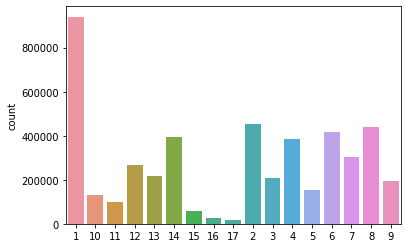

In [ ]:
sns.countplot(x=flat_list)

In [ ]:
del flat_list

In [8]:
lens = [len(seq) for seq in all_sequences]

### General length statistics

In [10]:
# Average length in the dataset
sum(lens) / len(all_sequences)

4.747129270229476

In [11]:
# Min length, max length
min(lens), max(lens)

(1, 14795)

### Plot showing the distribution of sequence lengths in the dataset

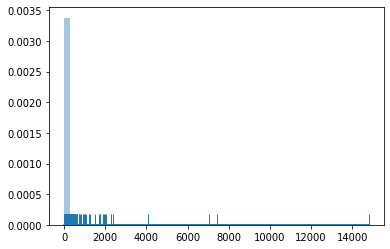

In [12]:
# plt.figure(figsize=(20, 6))

plt = sns.distplot(lens, kde=True, rug=True)
plt.get_figure().savefig("distribution_lengths.png")

# Algorithm implementation
The algorithm is comprised of 3 steps:
1. Compute frequent 1-sequences
2. Compute frequent 2-sequences
3. Compute all frequent n-sequences recursively

Before these 3 steps, the data is converted to the vertical format in a pre-processing step

In [17]:
MIN_SUP = 0.1
TOTAL_ELEMENTS = len(all_sequences)

### Convert to vertical format:

In [54]:
def convert_to_vertical_format(all_sequences):
    row_dicts = []
    for seq_id, seq in enumerate(all_sequences):
        for ele_id, element in enumerate(seq):
            row_dicts.append({"SID": seq_id, "EID": ele_id, "element": int(element)})
    df = pd.DataFrame(row_dicts)
    return df

In [55]:
%%time

df = convert_to_vertical_format(all_sequences)
groups = df.groupby(['element'])

CPU times: user 4.12 s, sys: 475 ms, total: 4.6 s
Wall time: 4.6 s


In [56]:
del all_sequences

### Generate frequent 1 itemsets:

In [57]:
def get_one_itemsets():
    one_id_list = {}
    for ele, group in groups:
        sup = group["SID"].nunique()/TOTAL_ELEMENTS
        if sup > MIN_SUP:
            one_id_list[ele] = group
    return one_id_list

In [58]:
# All the frequent 1-sequences
one_item_set = get_one_itemsets()
one_item_set.keys()

dict_keys([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14])

### Generate frequent 2 itemsets:

In [60]:
## Convert freq one item sets to a dict with following (horizontal) structure:
# keys = SID
# value = list with each element -> (item, EID)

def convert_to_horizontal_format():
    horizontal_id_list = {}
    for ele, id_list in tqdm(one_item_set.items()):
        for idx, row in id_list.iterrows():
            if row.SID in horizontal_id_list:
                horizontal_id_list[row.SID].append((ele, row.EID))
            else:
                horizontal_id_list[row.SID] = [(ele, row.EID)]
    return horizontal_id_list

In [61]:
horizontal_id_list = convert_to_horizontal_format()

In [62]:
## Number of unique sequences from the frequent-1 id list 
len(horizontal_id_list)

490791

In [63]:
sys.getsizeof(horizontal_id_list) / (1024*1024)

20.000091552734375

In [64]:
def get_two_itemsets():
    two_id_list = {}
    for sid, seq in tqdm(horizontal_id_list.items()):
        for i in range(len(seq)):
            ele1 = seq[i]
            for j in range(i+1, len(seq)):
                ele2 = seq[j]
                if ele1[1] < ele2[1]:
                    item = (ele1[0],) + (ele2[0],)
                    if item in two_id_list:
                        two_id_list[item].append((sid, ele1[1], ele2[1]))
                    else:
                        two_id_list[item] = [(sid, ele1[1], ele2[1])]
                if ele1[1] > ele2[1]:
                    item = (ele2[0],) + (ele1[0],)
                    if item in two_id_list:
                        two_id_list[item].append((sid, ele2[1], ele1[1]))
                    else:
                        two_id_list[item] = [(sid, ele2[1], ele1[1])]
    return two_id_list 

In [65]:
two_id_list = get_two_itemsets()

In [66]:
def get_unique_sids(id_list):
    prev = -1
    count = 0
    for sid, _, _ in id_list:
        if prev != sid:
            count += 1
        prev = sid
    return count

In [67]:
non_freq = []
for ele, pairs in two_id_list.items():
    d = get_unique_sids(pairs)
    if d/TOTAL_ELEMENTS <= MIN_SUP:
        non_freq.append(ele)
for item in non_freq:
    del two_id_list[item]

In [68]:
## All the frequent 2-sequences
s = sorted(two_id_list.items(), key = lambda x: x[0][0])
for k, v in s:
    print(k)

(1, 1)
(1, 2)
(1, 12)
(2, 1)
(2, 2)
(4, 4)
(6, 6)
(7, 7)
(8, 8)
(9, 9)
(12, 12)
(13, 13)
(14, 14)


In [69]:
del horizontal_id_list

### Generate frequent-n itemsets:

In [70]:
global_frequent_patterns = {}

In [71]:
def temporal_join(item_i, id_list_i, item_j, id_list_j):
    # Do temporal join
    # return a dict of {freq_item: id_list, ...}
    joined = {}
    if item_i[:len(item_i)-1] != item_j[:len(item_j)-1]:
        return joined

    item1 = item_i + (item_j[-1],)
    item2 = item_j + (item_i[-1],)

    df_id_list_1 = pd.DataFrame(id_list_i)
    df_id_list_2 = pd.DataFrame(id_list_j)

    for sid in tqdm(df_id_list_1[0].unique(), desc="unique sids"):

        id_list_1 = df_id_list_1[df_id_list_1[0] == sid]
        id_list_2 = df_id_list_2[df_id_list_2[0] == sid]

        if id_list_1.empty or id_list_2.empty:
            continue

        id_list_1 = [tuple(x) for x in id_list_1.values]
        id_list_2 = [tuple(x) for x in id_list_2.values]
        
        for event_i in id_list_1:
            for idx, event_j in enumerate(id_list_2):
                if event_i[0] == event_j[0]:
                    if event_i[1:len(event_i)-1] == event_j[1:len(event_j)-1]:

                        if event_i[-1] < event_j[-1]:
                            if item1 not in joined:
                                joined[item1] = []
                            joined[item1].append(event_i + (event_j[-1],))

                        elif event_i[-1] > event_j[-1]:
                            if item2 not in joined:
                                joined[item2] = []
                            joined[item2].append(event_j + (event_i[-1],))
    
    return joined

In [72]:
# add patterns to global freq patterns
# if patterns is empty then return
# else recursively call fn on patterns
def enumerate_frequent_sequences(freq_patterns):
    patterns = {}
    for idx_i, item_i in enumerate(list(freq_patterns.keys())):
        id_list_i = freq_patterns[item_i]
        for idx_j, item_j in enumerate(list(freq_patterns.keys())[idx_i+1:]):
            id_list_j = freq_patterns[item_j]
            combined = temporal_join(item_i, id_list_i, item_j, id_list_j)
            for k, v in combined.items():
                if k in patterns:
                    patterns[k].extend(v)
                else:
                    patterns[k] = v
    
    for k, v in patterns.items():
        if len(v)/TOTAL_ELEMENTS > MIN_SUP:
            if k in global_frequent_patterns:
                global_frequent_patterns[k].extend(v)
            else:
                global_frequent_patterns[k] = v

    if not patterns:
        return
    else:
        enumerate_frequent_sequences(patterns)

In [ ]:
%%time
enumerate_frequent_sequences(two_id_list)

In [ ]:
def get_all_frequent_items():
    all_frequent_items = [(x,) for x in list(one_item_set.keys())]
    all_frequent_items.extend(list(two_id_list.keys()))
    all_frequent_items.extend(list(global_frequent_patterns))
    return all_frequent_items

In [ ]:
frequent_items = get_all_frequent_items()

In [ ]:
frequent_items